Notebook to test the reimplementation of the Compton subtraction method, including helper functions. Written 20190708


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../../")
import ompy

%load_ext autoreload
%matplotlib notebook

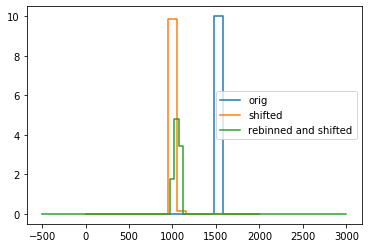

In [2]:
# Test the rebin_and_shift function

N = 20
E_array = np.linspace(0, 2000, N)
counts = np.zeros(N)
counts[15] = 10

# Test shift() function:
counts_shifted = ompy.shift(counts, E_array_in=E_array, energy_shift=-525)

# Test rebin_and_shift() function:
E_array_rebin = np.linspace(-500, 3000, N+50)
counts_rebinned_and_shifted = ompy.rebin_and_shift(counts, E_array_in=E_array, E_array_out=E_array_rebin, energy_shift=-525)


f, ax = plt.subplots(1)

ax.step(E_array, counts, label="orig")
ax.step(E_array, counts_shifted, label="shifted")
ax.step(E_array_rebin, counts_rebinned_and_shifted, label="rebinned and shifted")

ax.legend()


plt.show()

# Test the compton subtraction method

In [3]:
raw = ompy.read_mama_2D("Si28_raw_matrix_compressed.m")

folder_response = "../../oscar2017_scale1.15"
#response, fwhm_rel, Eff_tot, pcmp, pFE, pSE, pDE, p511 = ompy.response(folder_response, raw.E1_array, fwhm_abs=6.8)

unfolder = ompy.Unfolder(folder_response, matrix=raw, fwhm=6.8)

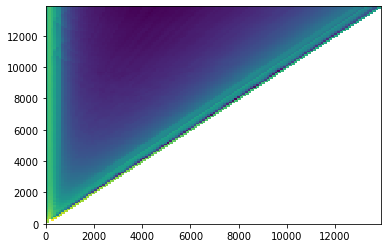

In [4]:
unfolder.response_matrix.plot()

../../ompy/unfold.py:347: RuntimeWarning: invalid value encountered in true_divide
  fluctuations_matrix = fluctuations_matrix/fluctuations_vector_raw[:,None] # TODO check that this broadcasts the vector over the right dimension


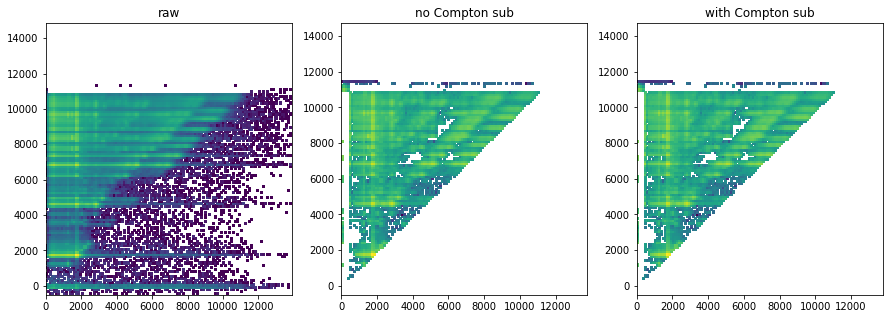

In [5]:
# Run unfolding without Compton subtraction:
unfolded_no_compton = unfolder.unfold(raw, use_comptonsubtraction=False)

# Run unfolding again WITH Compton subtraction:
unfolded_with_compton = unfolder.unfold(raw, use_comptonsubtraction=True)


# Plot:
f, (ax0, ax1, ax2) = plt.subplots(1, 3)

# Plot raw:
raw.plot(ax=ax0, title="raw")

# Plot unfolded without Compton subtraction method:
unfolded_no_compton.plot(ax=ax1, title="no Compton sub")

# Plot unfolded with Compton subtraction method:
unfolded_with_compton.plot(ax=ax2, title="with Compton sub")

f.set_size_inches(15, 5)